In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from IPython.display import Image  
import pydotplus

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.getcwd()

'/content'

In [0]:
dataUnstructured = pd.read_csv("/content/drive/My Drive/spotify.csv")
dataUnstructured = dataUnstructured.iloc[:,1:] #The first column were just row indices, so I removed it.

First, I will check if any of the columns have any missing values.

In [0]:
for i in range(0,len(dataUnstructured.columns)):
    missing = [0] * len(dataUnstructured.columns)
    missing[i] = dataUnstructured.iloc[:,i].isna().sum()

pd.DataFrame({"Column":dataUnstructured.columns,"# of Missing Rows":missing}) 

,Column,# of Missing Rows
0,album,0
1,artist,0
2,genre,0
3,track_name,0
4,acousticness,0
5,danceability,0
6,duration_ms,0
7,energy,0
8,instrumentalness,0
9,key,0


Neither the outcome nor the features I'm interested in have any missing values. I decided to remove the columns that I won't be using, such that only the outcome and features remain in the data:

In [0]:
relevantColumns = ["genre","acousticness","danceability","energy","instrumentalness",
                   "liveness","loudness","speechiness","tempo","valence"]
data=dataUnstructured.loc[:,relevantColumns]
data.head()

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Pop,0.348,0.591,0.718,0.000118,0.107,-6.025,0.0368,117.995,0.468
1,Pop,0.133,0.568,0.686,0.000000,0.110,-4.901,0.0903,148.294,0.400
2,Pop,0.648,0.600,0.535,0.000005,0.162,-7.043,0.1070,71.912,0.269
3,Pop,0.779,0.587,0.299,0.000000,0.123,-7.365,0.0263,94.992,0.356
4,Pop,0.568,0.479,0.419,0.000217,0.110,-6.517,0.0389,85.014,0.186


The following table shows the mean of the audio features by genre:

In [0]:
data.groupby("genre").agg("mean").round(3).reset_index()

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Classical,0.961,0.317,0.118,0.768,0.147,-21.353,0.045,105.508,0.356
1,Country,0.169,0.562,0.706,0.004,0.183,-6.030,0.045,123.619,0.553
2,Gaming,0.242,0.555,0.613,0.246,0.169,-8.797,0.086,117.114,0.405
3,Hip Hop,0.136,0.720,0.744,0.004,0.233,-5.841,0.238,113.812,0.610
4,Jazz,0.659,0.562,0.328,0.585,0.158,-13.811,0.076,109.743,0.417
5,K-pop,0.312,0.632,0.687,0.002,0.185,-4.844,0.084,119.037,0.508
6,Pop,0.209,0.619,0.701,0.004,0.196,-5.747,0.069,121.724,0.531
7,Rock,0.103,0.502,0.753,0.039,0.183,-6.954,0.059,123.832,0.494
8,reggae,0.163,0.762,0.619,0.113,0.163,-8.213,0.127,118.844,0.738


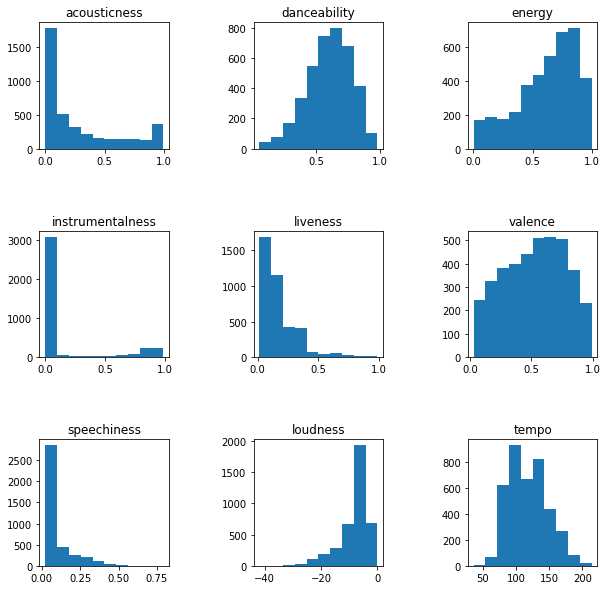

In [0]:
dummy=np.array([
    ["acousticness","danceability","energy"],
    ["instrumentalness","liveness","valence"],
    ["speechiness","loudness","tempo"]
    ])

fig,axis=plt.subplots(3,3,figsize=(10,10)) 
fig.subplots_adjust(hspace=0.65,wspace=0.65)

for i in range(0,3):
    for j in range(0,3):
        axis[i,j].set_title(dummy[i,j])

for i in range(0,3):
    for j in range(0,3):
        axis[i,j].hist(data[dummy[i,j]])

### **Prediction of Song Genre Based on Audio Features**

In [0]:
y=data["genre"]
X=data.iloc[:,1:]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

**Classification Tree**

Text(0.5, 1.0, 'Accuracy of Decision Tree by Max Depth')

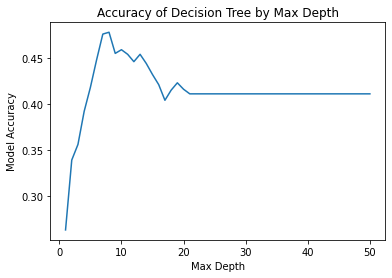

In [0]:
max_depth=list(range(1,51))
accuracy=[0]*50
for i in range(1,51):
    classifier=DecisionTreeClassifier(max_features=None,splitter="best",criterion="gini",random_state=42,
                                      max_depth=i)
    fittedModel=classifier.fit(X_train,y_train)
    predictions=fittedModel.predict(X_test)
    accuracy[i-1]=accuracy_score(y_test,predictions).round(3)

plt.plot(max_depth,accuracy)
plt.xlabel("Max Depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy of Decision Tree by Max Depth")

My decision tree's measure of accuracy is the proportion of observations that it correctly predicts. Recall that a prediction can be any one of the nine song genres, such that an accuracy higher than $\frac{1}{9}$ would be better than randomly guessing.  Having varied the max depth (the tree's degree of complexicity) up to 50, model accuracy seems to be the highest at a max depth of around 7 or 8.

In [0]:
iterations=pd.DataFrame({"Max Depth":max_depth,"Accuracy":accuracy})
iterations["Accuracy"].idxmax() #returns the max_depth with the highest accuracy

7

In [20]:
iterations.iloc[6,:]

Max Depth    7.000
Accuracy     0.476
Name: 6, dtype: float64

In [21]:
finalClassifier=DecisionTreeClassifier(max_features=None,splitter="best",criterion="gini",random_state=42,
                                       max_depth=7)
fittedModel=finalClassifier.fit(X,y)
fittedModel

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

To see if we can improve the accuracy of our decision tree past 47%, let's now specify two more models:
- Bagged Classification Tree
- Boosted Classification Tree

**Bagged Classification Tree**